In [1]:
from optvis import *
import torchvision.models as models

In [2]:
# see https://pytorch.org/docs/stable/torchvision/models.html
m = models.resnet50(pretrained=True).eval().cuda()

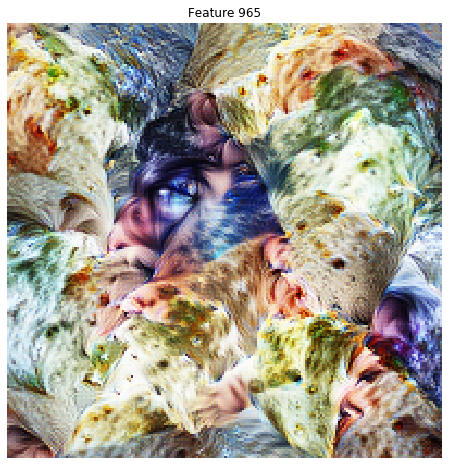

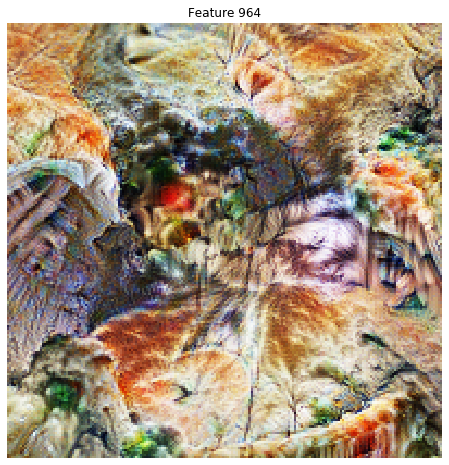

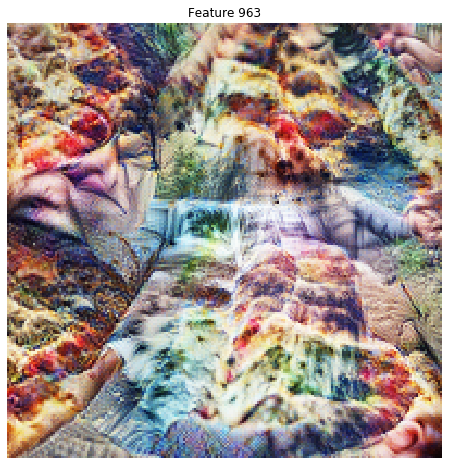

In [3]:
for feat in [965, 964, 963]:
    img = visualize_feature(m, m.fc, feat)    
    show_image(img, label=f"Feature {feat}")